In [ ]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
training_dir = '/content/drive/MyDrive/Mega_project_(DBDA)/chest_xray/train'
validation_dir = '/content/drive/MyDrive/Mega_project_(DBDA)/chest_xray/val'
test_dir = '/content/drive/MyDrive/Mega_project_(DBDA)/chest_xray/test'

##**Inception_V3**

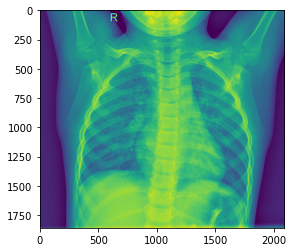

In [ ]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:

def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

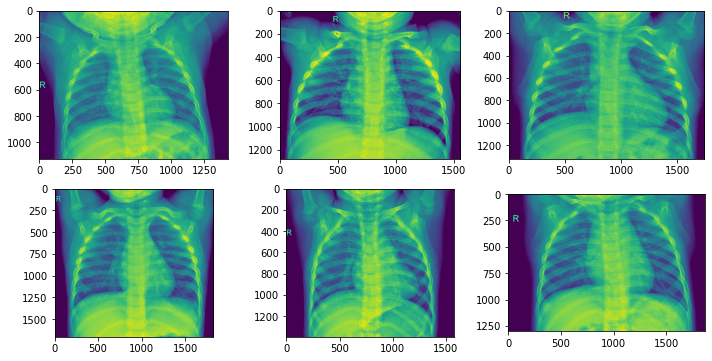

In [ ]:
plot_images(training_dir + '/NORMAL')

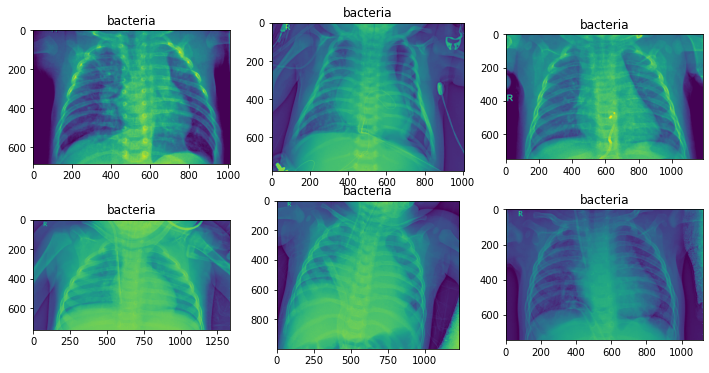

In [ ]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

In [ ]:
# Define path to the data directory
dir_alldata = Path('/content/drive/MyDrive/Mega_project_(DBDA)/chest_xray')

In [ ]:
# Path to train directory (Fancy pathlib...no more os.path!!)
train_data_dir = dir_alldata / 'train'

# Path to validation directory
validation_data_dir = dir_alldata / 'val'

# Path to test directory
test_data_dir = dir_alldata / 'test'

# Get the path to the normal and pneumonia sub-directories
normal_cases_train = train_data_dir / 'NORMAL'
pneumonia_cases_train = train_data_dir / 'PNEUMONIA'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of Positive (0) and Negative Cases (1)')

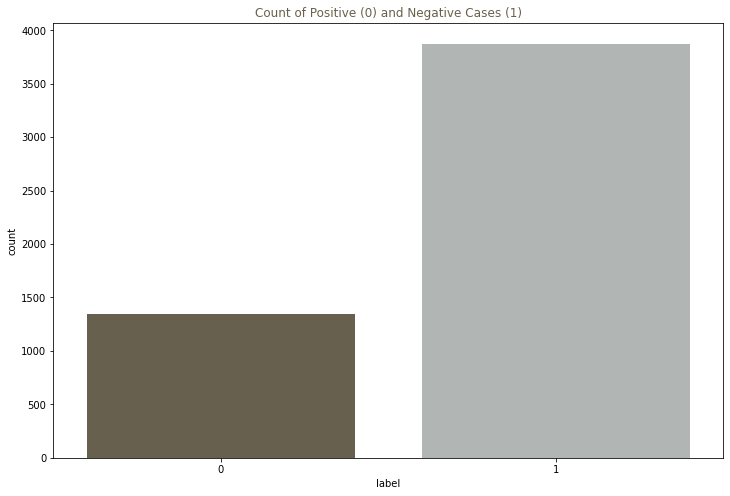

In [ ]:


# Get the list of all the images
normal =normal_cases_train.glob('*.jpeg')
pneumonia = pneumonia_cases_train.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal:
    train_df.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia:
    train_df.append((img,1))

# Get a pandas dataframe from the data we have in our list 
train_df = pd.DataFrame(train_df, columns=['image', 'label'],index=None)

# Shuffle the data 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
plt.figure(figsize=(12,8))
count = sns.countplot(train_df["label"], palette=["#6B614B","#B0B7B5"])
count.set_title("Count of Positive (0) and Negative Cases (1)", color="#6B614B")

In [ ]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
def get_model():

  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [ ]:
model = get_model()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________________

In [ ]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 1379s 8s/step - loss: 0.5157 - accuracy: 0.8415 - val_loss: 1.4861 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 79s 484ms/step - loss: 0.2004 - accuracy: 0.9200 - val_loss: 1.3952 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 78s 476ms/step - loss: 0.2046 - accuracy: 0.9215 - val_loss: 0.6159 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 78s 480ms/step - loss: 0.1728 - accuracy: 0.9348 - val_loss: 0.6542 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 78s 477ms/step - loss: 0.1857 - accuracy: 0.9297 - val_loss: 0.8488 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 79s 483ms/step - loss: 0.1749 - accuracy: 0.9241 - val_loss: 0.5854 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 78s 478ms/step - loss: 0.1813 - accuracy: 0.9272 - val_loss: 0.7784 - val_acc

In [ ]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


624/624 [==============================] - 129s 207ms/step - loss: 0.3840 - accuracy: 0.8766
Loss: 0.38404232263565063
Accuracy: 0.8766025900840759


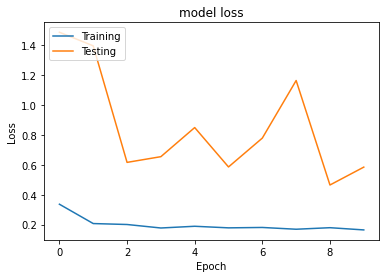

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='upper left')
plt.show()

In [ ]:
print (y_test , y_predt)

SyntaxError: ignored

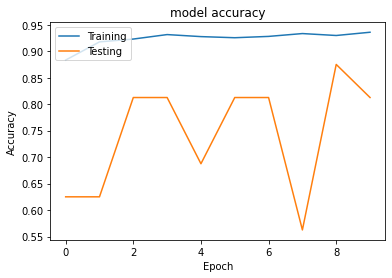

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='upper left')
plt.show()

In [ ]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),

In [ ]:
y_pred_batches

[array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),

In [ ]:

def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1

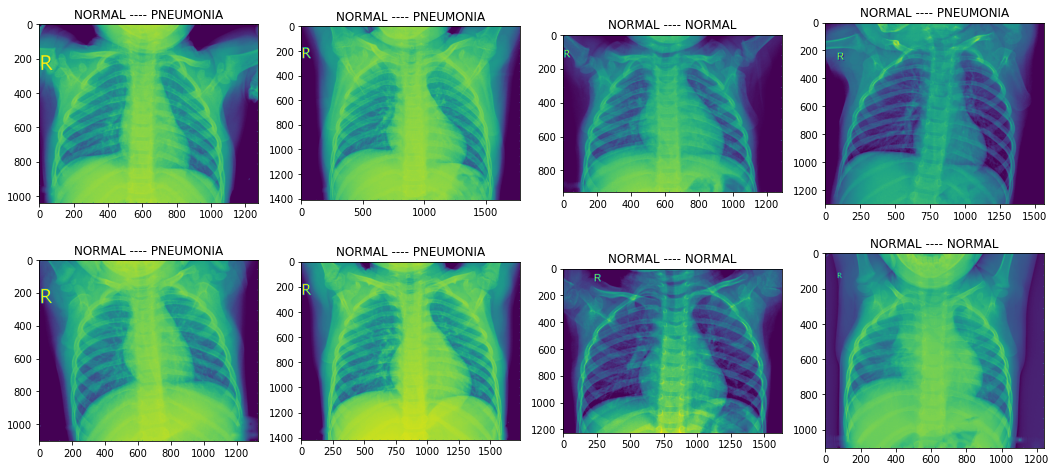

In [ ]:
predict_images('/content/drive/MyDrive/Mega_project_(DBDA)/chest_xray/val/NORMAL', 'NORMAL')

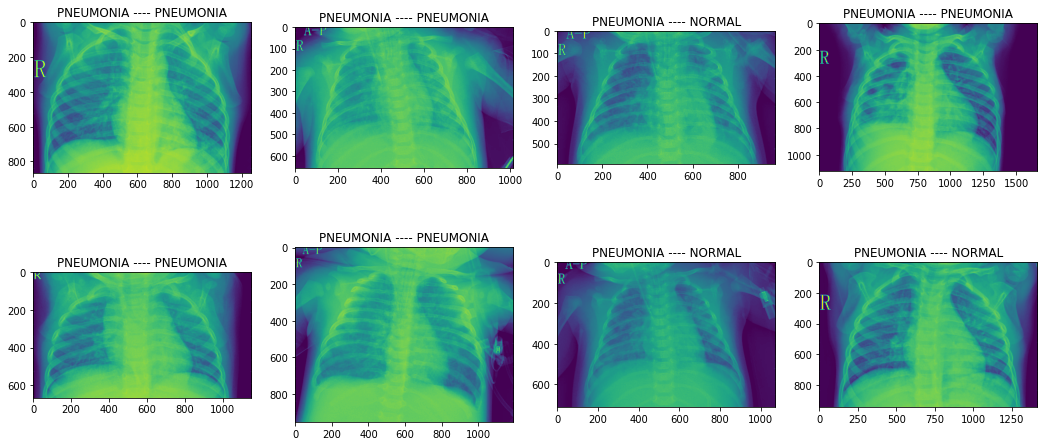

In [ ]:
predict_images('/content/drive/MyDrive/Mega_project_(DBDA)/chest_xray/val/PNEUMONIA', 'PNEUMONIA')